# CREDIT RISK ASSESSMENT

## IMPORTING NECESSARY LIBRARIES

In [48]:
import pandas as pd #To work with dataset
import numpy as np #Math library
import seaborn as sns #Graph library that use matplot in background
import matplotlib.pyplot as plt #to plot some parameters in seaborn
import plotly.offline as py 
from plotly import tools
from scipy.stats import chi2_contingency
py.init_notebook_mode(connected=True) # this code, allow us to work with offline plotly version
import plotly.graph_objs as go # it's like "plt" of matplot
import plotly.tools as tls # It's useful to we get some tools of plotly
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

## LOAD THE DATASET

In [2]:
df=pd.read_csv("german_credit_data.csv")
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


## UNDERSTANDING THE DATA

### 1. INFORMATION ABOUT THE DATA

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
dtypes: int64(5), object(5)
memory usage: 78.2+ KB
None


### 2. CHECKING NULL VALUES

In [4]:
print(df.isnull().sum())

Unnamed: 0            0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64


### 3. DATA DESCRIPTION

In [5]:
print(df.describe())

        Unnamed: 0          Age          Job  Credit amount     Duration
count  1000.000000  1000.000000  1000.000000    1000.000000  1000.000000
mean    499.500000    35.546000     1.904000    3271.258000    20.903000
std     288.819436    11.375469     0.653614    2822.736876    12.058814
min       0.000000    19.000000     0.000000     250.000000     4.000000
25%     249.750000    27.000000     2.000000    1365.500000    12.000000
50%     499.500000    33.000000     2.000000    2319.500000    18.000000
75%     749.250000    42.000000     2.000000    3972.250000    24.000000
max     999.000000    75.000000     3.000000   18424.000000    72.000000


## PREPROCESSING OF DATA

### 1. FILLING MISSING VALUES

In [6]:
df.fillna(df.mean(), inplace=True)
print(df.isnull().sum())

Unnamed: 0            0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64


### 2. DISTRIBUTION OF DATA

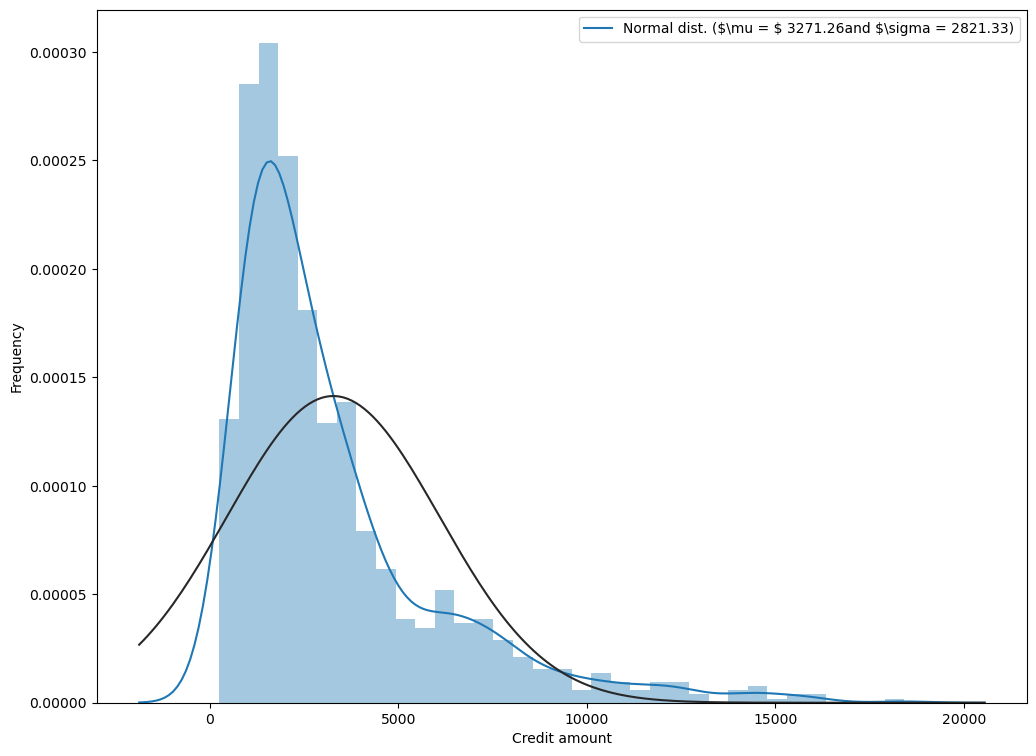

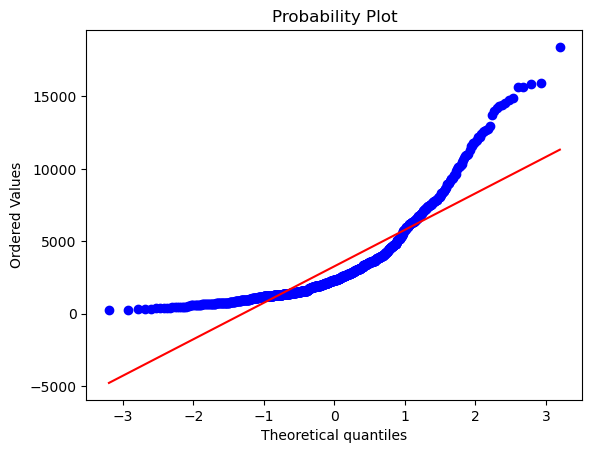

In [8]:
## Checking the distribution of the data
plt.subplots(figsize=(12,9))
sns.distplot(df['Credit amount'], fit = stats.norm)

# get the fitted parameters used by the function
(mu,sigma)= stats.norm.fit(df['Credit amount'])

#plot with distribution 
plt.legend(['Normal dist. ($\mu = $ {:.2f}and $\sigma = {:.2f})'.format(mu,sigma)], loc='best')
plt.ylabel('Frequency')

#PROBABILITY PLOT
fig = plt.figure()
stats.probplot(df['Credit amount'],plot=plt)
plt.show()

### 3. NORMALIZING THE DATA

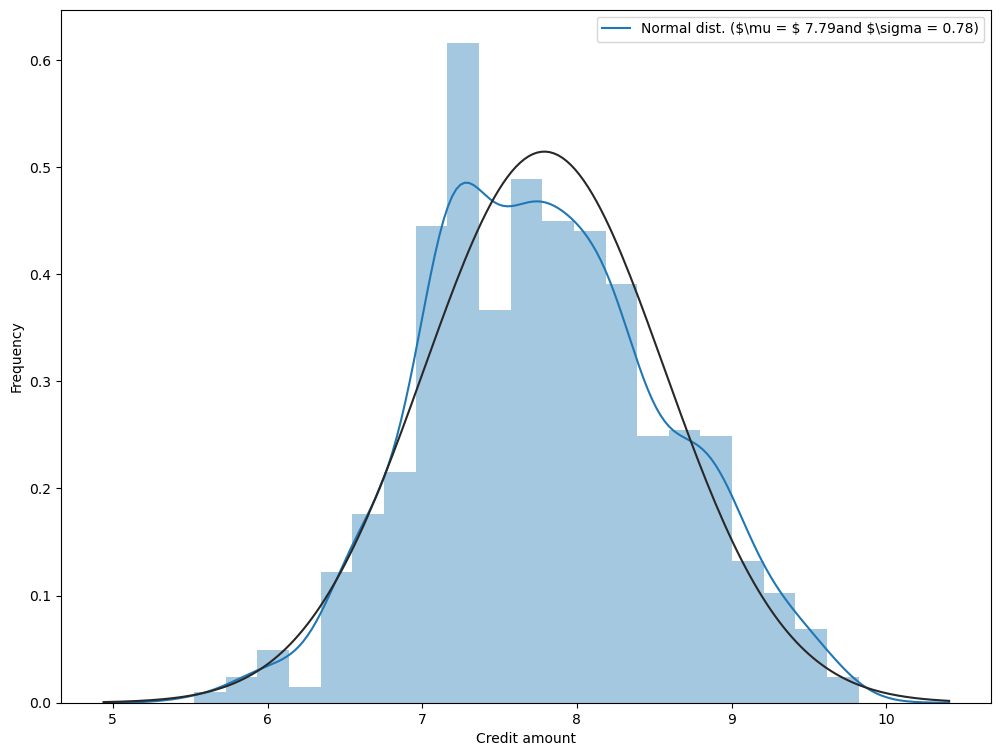

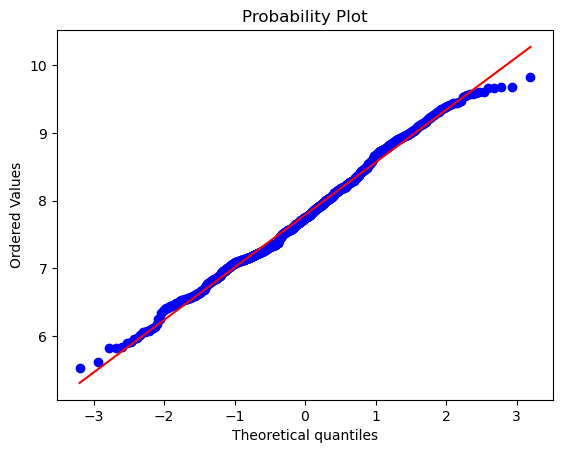

In [9]:

## We use the log which is a part of numpy library

df['Credit amount'] = np.log1p(df['Credit amount'])

#Check again for normal distribution 
plt.subplots(figsize =(12,9))
sns.distplot(df['Credit amount'], fit = stats.norm)

#get the fitted parameters used by the function
(mu,sigma)= stats.norm.fit(df['Credit amount'])

#plot with the distribution
plt.legend(['Normal dist. ($\mu = $ {:.2f}and $\sigma = {:.2f})'.format(mu,sigma)], loc='best')
plt.ylabel('Frequency')

#Probability plot
fig = plt.figure()
stats.probplot(df['Credit amount'],plot=plt)
plt.show()

## EXPLORATORY DATA ANALYSIS

### 1. TARGET VARIABLE DISTRIBUTION ON RISK CATEGORY

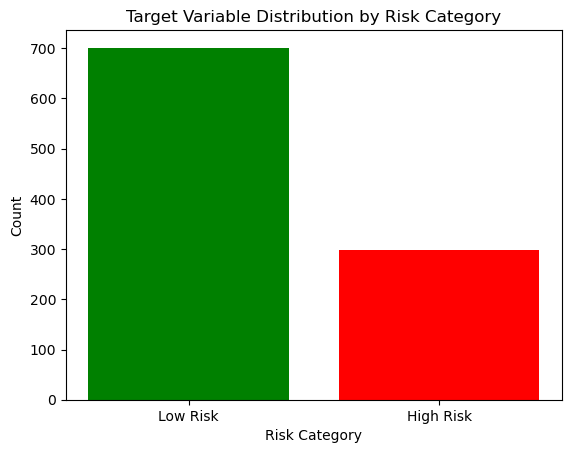

In [10]:

# Calculating the 70th percentile for 'Credit amount' to define 'low risk'
low_risk_threshold = df["Credit amount"].quantile(0.70)

# Creating bins based on the threshold
bins = [-float("inf"), low_risk_threshold, float("inf")]

# Creating labels for risk categories
labels = ['low', 'high']

# Creating a new column 'Risk Category' based on the thresholds
df['Risk Category'] = pd.cut(df['Credit amount'], bins=bins, labels=labels, include_lowest=True)

# Mapping 'Risk Category' to 'Risk'
risk_mapping = {
    'low': 'good',
    'high': 'bad'
}

df['Risk'] = df['Risk Category'].map(risk_mapping)

# Dropping the temporary 'Risk Category' column
df = df.drop(columns=['Risk Category'])

# Filtering the data into low and high-risk categories
low_risk_data = df[df['Risk'] == 'good']
high_risk_data = df[df['Risk'] == 'bad']

# Count the number of entries for each category
low_risk_count = low_risk_data.shape[0]
high_risk_count = high_risk_data.shape[0]

# Data for the bar chart
categories = ['Low Risk', 'High Risk']
count_data = [low_risk_count, high_risk_count]

plt.bar(categories, count_data, color=['green', 'red'])
plt.xlabel('Risk Category')
plt.ylabel('Count')
plt.title('Target Variable Distribution by Risk Category')
plt.show()


### 2. AGE DISTRIBUTION ON CREDIT CATEGORY

In [11]:
df_good = df.loc[df["Risk"] == 'good']['Age'].values.tolist()
df_bad = df.loc[df["Risk"] == 'bad']['Age'].values.tolist()
df_age = df['Age'].values.tolist()

#First plot
trace0 = go.Histogram(x=df_good,histnorm='probability',name="Good Credit")

#Second plot
trace1 = go.Histogram(x=df_bad,histnorm='probability',name="Bad Credit")

#Third plot
trace2 = go.Histogram(x=df_age,histnorm='probability',name="Overall Age")

#Creating the grid
fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                          subplot_titles=('Good','Bad', 'General Distribuition'))

#setting the figs
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)

fig['layout'].update(showlegend=True, title='Age Distribuition', bargap=0.05)
py.iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

### 3. AGE COUNTING BY RISK

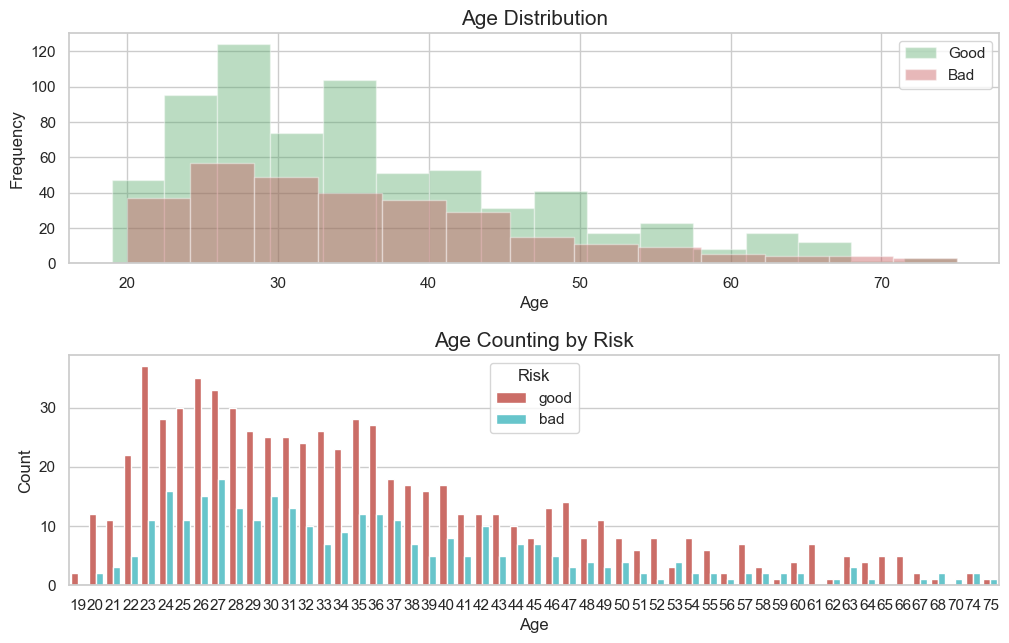

In [12]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=2, figsize=(12, 8))
plt.subplots_adjust(hspace=0.4, top=0.8)

sns.distplot(df[df["Risk"] == 'good']["Age"], ax=axes[0], color="g", label="Good", kde=False)
sns.distplot(df[df["Risk"] == 'bad']["Age"], ax=axes[0], color='r', label="Bad", kde=False)
axes[0].set_title("Age Distribution", fontsize=15)
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Frequency")
axes[0].legend()

sns.countplot(x="Age", data=df, palette="hls", ax=axes[1], hue="Risk")
axes[1].set_title("Age Counting by Risk", fontsize=15)
axes[1].set_xlabel("Age")
axes[1].set_ylabel("Count")

plt.show()



### 4. HOUSING DISTRIBUTION ON CREDIT CATEGORY

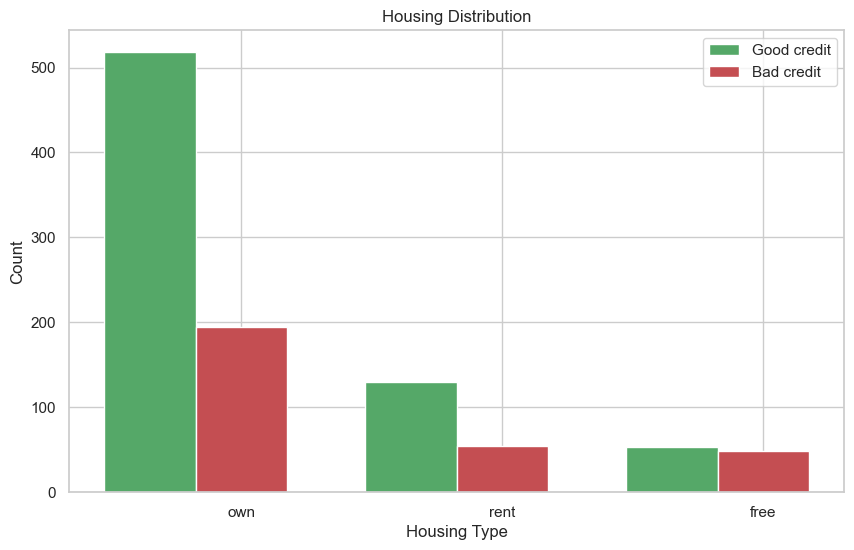

In [13]:
# Creating two subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Filtering data for 'good' and 'bad' credit
good_housing_counts = df[df["Risk"] == 'good']["Housing"].value_counts()
bad_housing_counts = df[df["Risk"] == 'bad']["Housing"].value_counts()

# Setting the bar width
bar_width = 0.35

# X-axis labels for the bars
x = range(len(good_housing_counts))

# Plot 'good' credit data
bar1 = plt.bar(x, good_housing_counts, width=bar_width, label='Good credit', color='g')

# Plot 'bad' credit data
bar2 = plt.bar([i + bar_width for i in x], bad_housing_counts, width=bar_width, label='Bad credit', color='r')


plt.xticks([i + bar_width for i in x], good_housing_counts.index)
plt.title('Housing Distribution')
plt.xlabel('Housing Type')
plt.ylabel('Count')
plt.legend()
plt.show()


### 5. DISTRIBUTION OF CREDIT AMOUNT BY RISK AND SEX

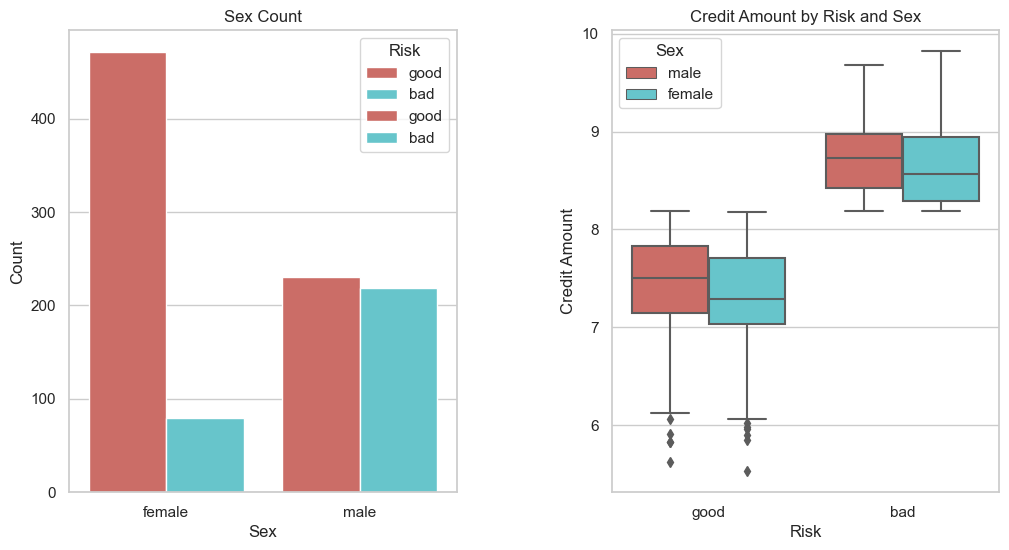

In [14]:
# Filter data for 'good' and 'bad' credit
good_credit_data = df[df["Risk"] == 'good']
bad_credit_data = df[df["Risk"] == 'bad']

# Creating a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.subplots_adjust(wspace=0.4)

# Creating a bar chart for 'Sex' count
sns.countplot(x="Sex", data=good_credit_data, palette="hls", ax=axes[0], hue="Risk")
sns.countplot(x="Sex", data=bad_credit_data, palette="hls", ax=axes[0], hue="Risk")
axes[0].set_title("Sex Count")
axes[0].set_xlabel("Sex")
axes[0].set_ylabel("Count")

# Creating box plots for 'Credit amount' by 'Sex'
sns.boxplot(x="Risk", y="Credit amount", data=df, hue="Sex", ax=axes[1], palette="hls")
axes[1].set_title("Credit Amount by Risk and Sex")
axes[1].set_xlabel("Risk")
axes[1].set_ylabel("Credit Amount")

plt.show()


### 6. JOB DISTRIBUTION BY RISK CATEGORY

In [15]:
job_mapping = {0: 'Unskilled and Non-Resident', 1: 'Unskilled and Resident', 2: 'Skilled', 3: 'Highly Skilled'}
df_mapped = df.replace({"Job": job_mapping})

# Group and count 'Job' values for good and bad credit
job_counts_good = df[df["Risk"] == 'good']["Job"].value_counts()
job_counts_bad = df[df["Risk"] == 'bad']["Job"].value_counts()

# Creating bar plots for good and bad credit distributions
set1 = go.Bar(
    x=job_counts_good.index,
    y=job_counts_good.values,
    name='Good credit Distribution'
)

set2 = go.Bar(
    x=job_counts_bad.index,
    y=job_counts_bad.values,
    name="Bad Credit Distribution"
)

data = [set1, set2]

layout = go.Layout(
    title='Job Distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='grouped-bar')


### 7. RISK ASSESSMENT BY SAVINGS ACCOUNT

In [16]:
import plotly.express as px

# Group and count 'Saving accounts' values for good and bad credit
saving_counts = df.groupby(['Saving accounts', 'Risk']).size().unstack().fillna(0)

# Creating an interactive bar plot
fig = px.bar(saving_counts, x=saving_counts.index, y=['good', 'bad'], 
             title='Risk Assessment by Saving accounts',
             labels={'Saving accounts': 'Saving accounts'},
             height=400)

fig.update_layout(barmode='group')
fig.show()


### 8. SAVINGS ACCOUNT EXPLORATION

In [17]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

'''# Define a mapping from numerical values to labels
saving_accounts_labels = {
    0: 'little',
    1: 'moderate',
    2: 'quite rich',
    3: 'rich'
}

# Map the values in the DataFrame to the labels
df['Saving accounts'] = df['Saving accounts'].map(saving_accounts_labels)'''

# Count of Saving Accounts
count_good = go.Bar(
    x=df[df["Risk"] == 'good']["Saving accounts"].value_counts().index.values,
    y=df[df["Risk"] == 'good']["Saving accounts"].value_counts().values,
    name='Good credit'
)
count_bad = go.Bar(
    x=df[df["Risk"] == 'bad']["Saving accounts"].value_counts().index.values,
    y=df[df["Risk"] == 'bad']["Saving accounts"].value_counts().values,
    name='Bad credit'
)

# Credit Amount by Saving Accounts
box_1 = go.Box(
    x=df[df["Risk"] == 'good']["Saving accounts"],
    y=df[df["Risk"] == 'good']["Credit amount"],
    name='Good credit'
)
box_2 = go.Box(
    x=df[df["Risk"] == 'bad']["Saving accounts"],
    y=df[df["Risk"] == 'bad']["Credit amount"],
    name='Bad credit'
)

# Age by Saving Accounts
scat_1 = go.Box(
    x=df[df["Risk"] == 'good']["Saving accounts"],
    y=df[df["Risk"] == 'good']["Age"],
    name='Good credit'
)
scat_2 = go.Box(
    x=df[df["Risk"] == 'bad']["Saving accounts"],
    y=df[df["Risk"] == 'bad']["Age"],
    name='Bad credit'
)

# Creating subplots
fig = make_subplots(rows=2, cols=2, subplot_titles=('Count Saving Accounts', 'Credit Amount by Savings Acc', 'Age by Saving accounts'))

# Adding traces to the subplots
fig.add_trace(count_good, row=1, col=1)
fig.add_trace(count_bad, row=1, col=1)
fig.add_trace(box_1, row=1, col=2)
fig.add_trace(box_2, row=1, col=2)
fig.add_trace(scat_1, row=2, col=1)
fig.add_trace(scat_2, row=2, col=1)

# Update layout
fig.update_layout(height=700, width=800, title_text='Saving Accounts Exploration', boxmode='group')

# Display the interactive plot
fig.show()


### 9. EXPLORATION OF PURPOSE VARIABLE

Values describe: 
Risk       0    1
Purpose          
0         45   52
1        125  212
2          1   11
3         15   44
4         52  129
5         48  232
6          5   17
7          8    4


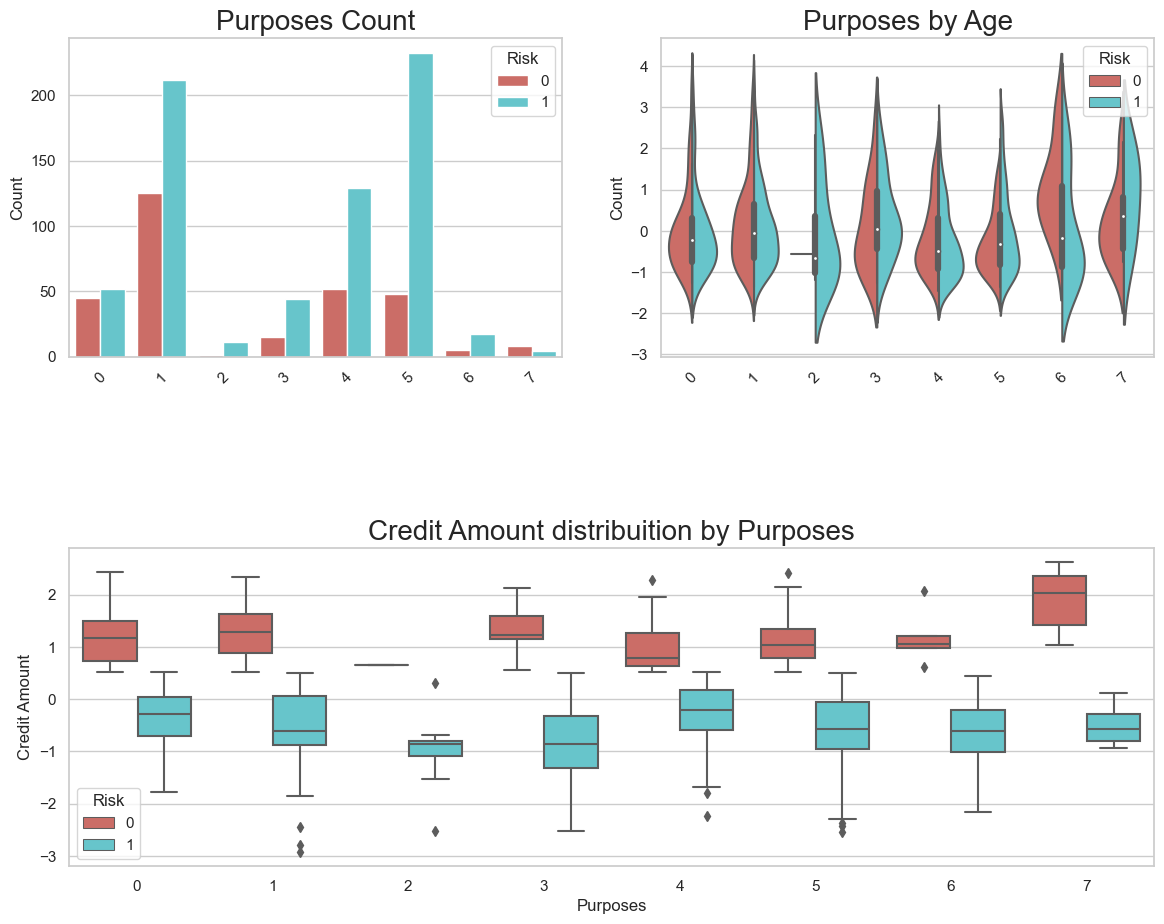

In [84]:
print("Values describe: ")
print(pd.crosstab(df.Purpose, df.Risk))

plt.figure(figsize = (14,12))

plt.subplot(221)
g = sns.countplot(x="Purpose", data=df, 
              palette="hls", hue = "Risk")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Count", fontsize=12)
g.set_title("Purposes Count", fontsize=20)

plt.subplot(222)
g1 = sns.violinplot(x="Purpose", y="Age", data=df, 
                    palette="hls", hue = "Risk",split=True)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
g1.set_xlabel("", fontsize=12)
g1.set_ylabel("Count", fontsize=12)
g1.set_title("Purposes by Age", fontsize=20)

plt.subplot(212)
g2 = sns.boxplot(x="Purpose", y="Credit amount", data=df, 
               palette="hls", hue = "Risk")
g2.set_xlabel("Purposes", fontsize=12)
g2.set_ylabel("Credit Amount", fontsize=12)
g2.set_title("Credit Amount distribuition by Purposes", fontsize=20)

plt.subplots_adjust(hspace = 0.6, top = 0.8)

plt.show()

### LABEL ENCODING

In [19]:
from sklearn.preprocessing import LabelEncoder
columns_to_encode = ['Sex', 'Housing',  'Purpose', 'Risk', 'Saving accounts','Checking account']

# Initializing the LabelEncoder
label_encoder = LabelEncoder()

# Applying label encoding to each column
for column in columns_to_encode:
    df[column] = label_encoder.fit_transform(df[column])

In [22]:
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,1,2,1,4,0,7.064759,6,5,1
1,1,22,0,2,1,0,1,8.691483,48,5,0
2,2,49,1,1,1,0,3,7.648263,12,3,1
3,3,45,1,2,0,0,0,8.972464,42,4,0
4,4,53,1,2,0,0,0,8.491055,24,1,0


### 10. CORRELATION ANALYSIS

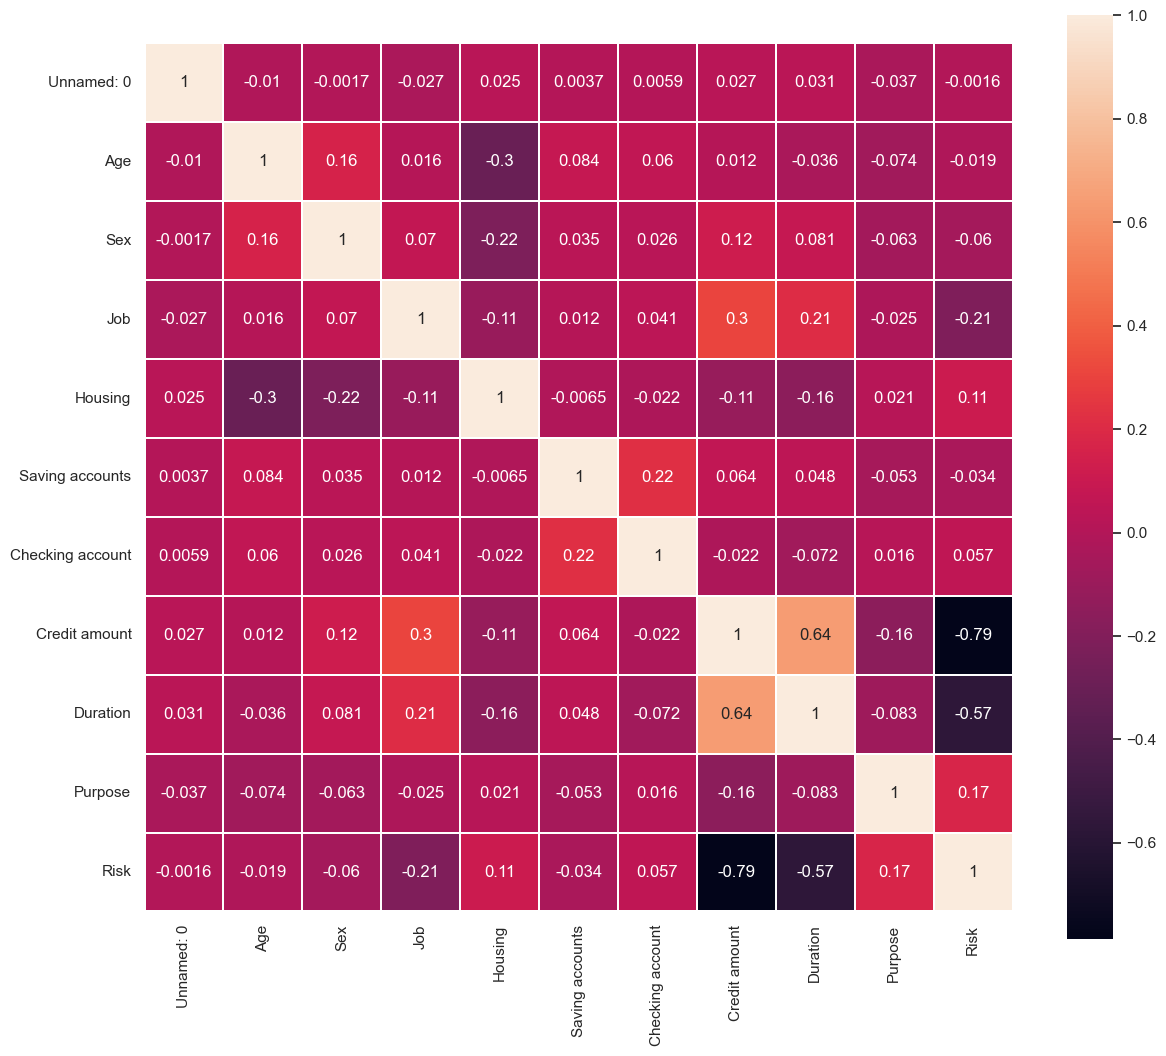

In [23]:
plt.figure(figsize=(14,12))
sns.heatmap(df.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True,  linecolor='white', annot=True)
plt.show()

In [24]:
df.dtypes

Unnamed: 0            int64
Age                   int64
Sex                   int32
Job                   int64
Housing               int32
Saving accounts       int32
Checking account      int32
Credit amount       float64
Duration              int64
Purpose               int32
Risk                  int32
dtype: object

### 11. CHI-SQUARE TEST

In [25]:
#Chi-Squared test to find if correlation is present b/w target and categorical features
def target_corr(col):
    contingency_table = pd.crosstab(df['Risk'], df[col])
    chi2, p_value, dof, expected_freq = chi2_contingency(contingency_table)
    if(p_value>0.05):
        print(f"No correlation b/w the target variable and {col}")
    else:
        print(f"Significant correlation b/w target and {col}")
        print(p_value)
        

#Results for different features
categorical = ["Sex","Job","Housing","Saving accounts","Checking account","Purpose","Risk"]
for col in categorical:
    if col == "Risk":
        pass
    else:
        target_corr(col)

No correlation b/w the target variable and Sex
Significant correlation b/w target and Job
7.994000799187941e-13
Significant correlation b/w target and Housing
2.8482158613907337e-06
Significant correlation b/w target and Saving accounts
0.005777260189683314
Significant correlation b/w target and Checking account
0.0059219955863373756
Significant correlation b/w target and Purpose
2.0809451712470795e-09


### 12. TOP BEST FEATURES FOR MODEL BUILDING

In [26]:
print('Find the most important features relative to the traget')
corr = df.corr()
corr.sort_values(['Risk'], ascending = False , inplace = True)
corr.Risk

Find the most important features relative to the traget


Risk                1.000000
Purpose             0.170709
Housing             0.112007
Checking account    0.056514
Unnamed: 0         -0.001631
Age                -0.018778
Saving accounts    -0.034032
Sex                -0.059932
Job                -0.209651
Duration           -0.565060
Credit amount      -0.786782
Name: Risk, dtype: float64

## MODEL BUILDING

### 1. SPLITTING THE DATASET

In [77]:
X = df[['Job', 'Housing','Saving accounts','Checking account', 'Duration', 'Purpose']]
y = df["Risk"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=100)

### 2. FEATURE SCALING

In [60]:
'''from sklearn.preprocessing import MinMaxScaler
# Create the MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler on the training data (compute min and max for scaling)
scaler.fit(X_train)

# Transform the training and testing data using the scaler
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_val)


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[['Duration', 'Credit amount', 'Job']] = scaler.fit_transform(df[['Duration', 'Credit amount', 'Job']])'''

### 3. TRAINING CLASSIFICATION MODELS


In [78]:
# Logistic Regression
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)


# Classification Trees
#base_classifier = RidgeClassifier(alpha=1.0)
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)

# Neural Networks
nn_model = MLPClassifier()
nn_model.fit(X_train, y_train)

MLPClassifier()

### 4. EVALUATION OF MODELS

In [79]:
# Logistic Regression
logistic_pred = logistic_model.predict(X_val)
logistic_cm = confusion_matrix(y_val, logistic_pred)

# Classification Trees
rf_pred = rf_model.predict(X_val)
rf_cm = confusion_matrix(y_val, rf_pred)

# Neural Networks
nn_pred = nn_model.predict(X_val)
nn_cm = confusion_matrix(y_val, nn_pred)

### 5. PRINTING EVALUATION RESULTS

In [80]:
# Logistic Regression
print("Logistic Regression:")
print("Confusion Matrix:")
print(logistic_cm)
logistic_accuracy = accuracy_score(y_val, logistic_pred)  
print("Logistic Regression Accuracy:", logistic_accuracy)
print(classification_report(y_val, logistic_pred))

# Classification Trees
print("\nClassification Trees:")
print("Confusion Matrix:")
print(rf_cm)
rf_accuracy = accuracy_score(y_val, rf_pred)
print("Classification Trees Accuracy:", rf_accuracy)
print(classification_report(y_val, rf_pred))

# Neural Networks
print("\nNeural Networks:")
print("Confusion Matrix:")
print(nn_cm)
nn_accuracy = accuracy_score(y_val, nn_pred)  
print("Neural Networks Accuracy:", nn_accuracy)
print(classification_report(y_val, nn_pred))

Logistic Regression:
Confusion Matrix:
[[ 31  28]
 [ 10 131]]
Logistic Regression Accuracy: 0.81
              precision    recall  f1-score   support

           0       0.76      0.53      0.62        59
           1       0.82      0.93      0.87       141

    accuracy                           0.81       200
   macro avg       0.79      0.73      0.75       200
weighted avg       0.80      0.81      0.80       200


Classification Trees:
Confusion Matrix:
[[ 38  21]
 [ 16 125]]
Classification Trees Accuracy: 0.815
              precision    recall  f1-score   support

           0       0.70      0.64      0.67        59
           1       0.86      0.89      0.87       141

    accuracy                           0.81       200
   macro avg       0.78      0.77      0.77       200
weighted avg       0.81      0.81      0.81       200


Neural Networks:
Confusion Matrix:
[[ 32  27]
 [ 12 129]]
Neural Networks Accuracy: 0.805
              precision    recall  f1-score   support

  

### 6. COMPARISON OF ACTUAL V/S FITTED LINES

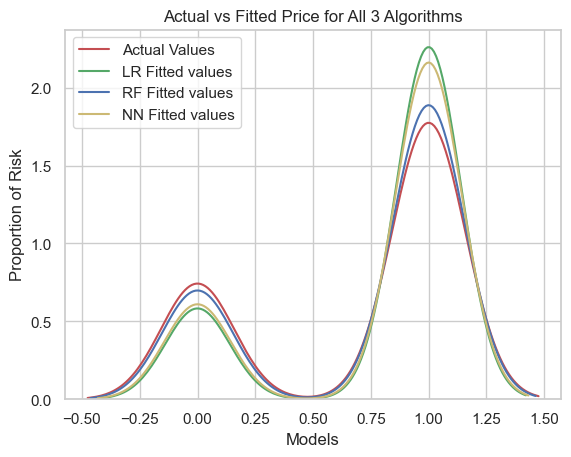

In [82]:
# distribution plot to compare Actual vs Predicted values for Price
ax1= sns.distplot(y_val,hist=False,color='r',label='Actual Values')
sns.distplot(logistic_pred,hist=False,color='g',label='LR Fitted values',ax=ax1)
sns.distplot(rf_pred,hist=False,color='b',label='RF Fitted values',ax=ax1)
sns.distplot(nn_pred,hist=False,color='y',label='NN Fitted values',ax=ax1)
plt.title('Actual vs Fitted Price for All 3 Algorithms')
plt.xlabel('Models')
plt.ylabel('Proportion of Risk')
plt.legend(loc='best')
plt.show()

### 6. CROSS-VALIDATION OF THE MODELS

LogisticRegression Accuracy: 0.82 (+/- 0.03)
RandomForestClassifier Accuracy: 0.79 (+/- 0.02)
MLPClassifier Accuracy: 0.80 (+/- 0.01)


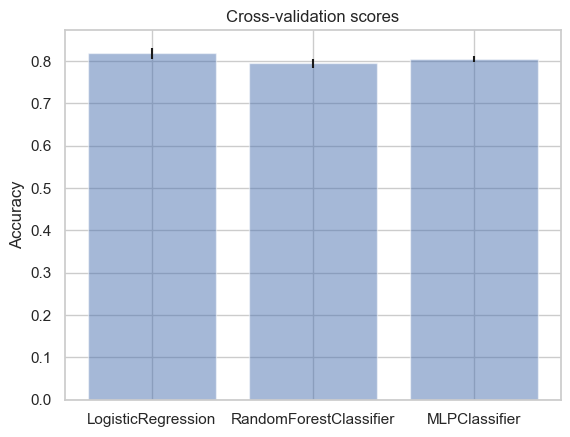

In [81]:
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

# List of models
models = [logistic_model, rf_model, nn_model]

# Performing cross-validation for each model
cv_scores = []

for model in models:
    scores = cross_val_score(model, X, y, cv=5)
    cv_scores.append(scores)

# Printing the mean and standard deviation of the scores
for i, model in enumerate(models):
    print(f"{model.__class__.__name__} Accuracy: {cv_scores[i].mean():.2f} (+/- {cv_scores[i].std() * 2:.2f})")


# Creating a bar plot for Cross validation
labels = [model.__class__.__name__ for model in models]
means = [scores.mean() for scores in cv_scores]
stds = [scores.std() for scores in cv_scores]
x_pos = np.arange(len(labels))

plt.bar(x_pos, means, yerr=stds, align='center', alpha=0.5)
plt.xticks(x_pos, labels)
plt.ylabel('Accuracy')
plt.title('Cross-validation scores')

plt.show()